In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score


df=pd.read_csv("D:/pro/Fraud.csv")
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [3]:
df.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

In [4]:
df['isFraud'].value_counts()

isFraud
0    6354407
1       8213
Name: count, dtype: int64

In [5]:
df.drop(['nameOrig', 'nameDest', 'isFlaggedFraud'], axis=1, inplace=True)

In [6]:
le = LabelEncoder()
df['type'] = le.fit_transform(df['type'])

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 8 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            int32  
 2   amount          float64
 3   oldbalanceOrg   float64
 4   newbalanceOrig  float64
 5   oldbalanceDest  float64
 6   newbalanceDest  float64
 7   isFraud         int64  
dtypes: float64(5), int32(1), int64(2)
memory usage: 364.1 MB


In [8]:
df.head()

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud
0,1,3,9839.64,170136.0,160296.36,0.0,0.0,0
1,1,3,1864.28,21249.0,19384.72,0.0,0.0,0
2,1,4,181.00,181.0,0.00,0.0,0.0,1
3,1,1,181.00,181.0,0.00,21182.0,0.0,1
4,1,3,11668.14,41554.0,29885.86,0.0,0.0,0


In [9]:
df['errorBalanceOrig'] = df['oldbalanceOrg'] - df['amount'] - df['newbalanceOrig']
df['errorBalanceDest'] = df['oldbalanceDest'] + df['amount'] - df['newbalanceDest']


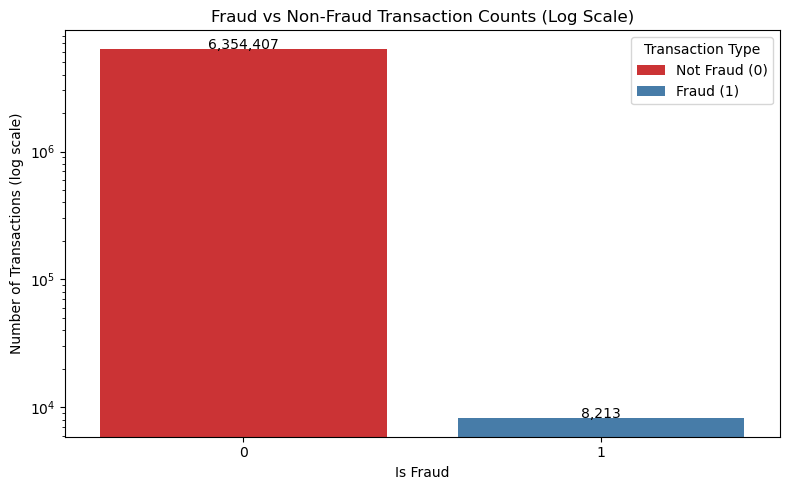

In [10]:



# Optional: Patch for manual legend (not needed with hue)
from matplotlib.patches import Patch

# Create plot with hue for different colors
plt.figure(figsize=(8, 5))
ax = sns.countplot(x='isFraud', data=df, hue='isFraud', palette='Set1')  # 👈 Use hue and palette

plt.yscale('log')
plt.title("Fraud vs Non-Fraud Transaction Counts (Log Scale)")
plt.xlabel("Is Fraud")
plt.ylabel("Number of Transactions (log scale)")

# Calculate fraud rate
total = len(df)
fraud_count = df['isFraud'].sum()
fraud_rate = (fraud_count / total) * 100

# Add bar labels
for p in ax.patches:
    value = int(p.get_height())
    label = f"{value:,}"
    # Add percentage on fraud bar (right bar)
    if int(p.get_x()) == 1:
        label += f"\n({fraud_rate:.2f}%)"
    ax.annotate(label, (p.get_x() + p.get_width()/2., value),
                ha='center', fontsize=10, color='black')

# Rename legend labels for clarity
ax.legend(title="Transaction Type", labels=["Not Fraud (0)", "Fraud (1)"])

plt.tight_layout()
plt.show()



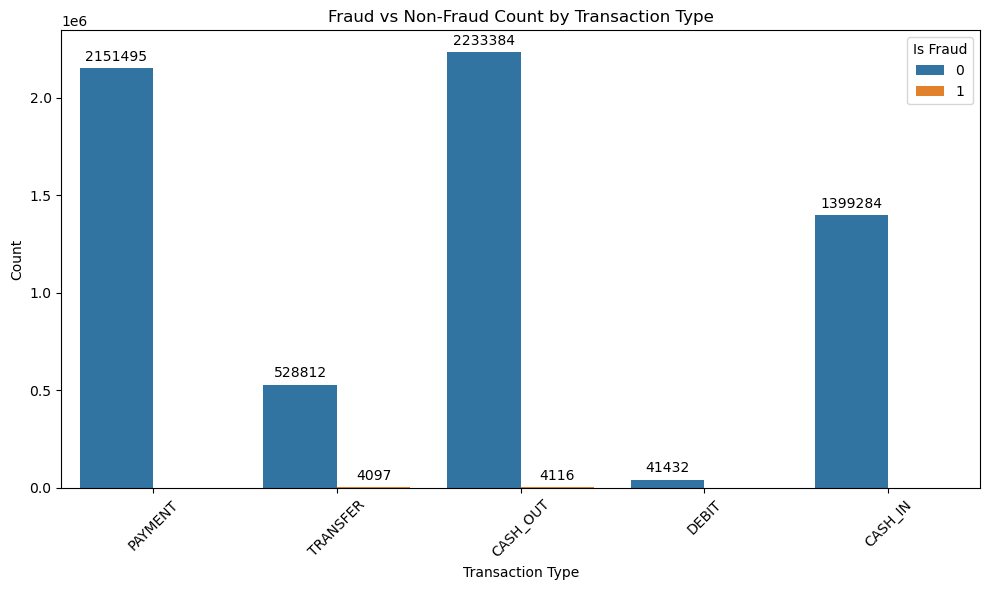

In [11]:

# Create mapping from encoded values to original labels
type_mapping = dict(zip(le.transform(le.classes_), le.classes_))

# Map the encoded type values back to readable labels
df['type_label'] = df['type'].map(type_mapping)

# Create the countplot
plt.figure(figsize=(10, 6))
ax = sns.countplot(x='type_label', hue='isFraud', data=df)
plt.title("Fraud vs Non-Fraud Count by Transaction Type")
plt.xlabel("Transaction Type")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.legend(title='Is Fraud')

# Add count labels on top of each bar
for container in ax.containers:
    ax.bar_label(container, fmt='%.0f', label_type='edge', padding=3)

plt.tight_layout()
plt.show()


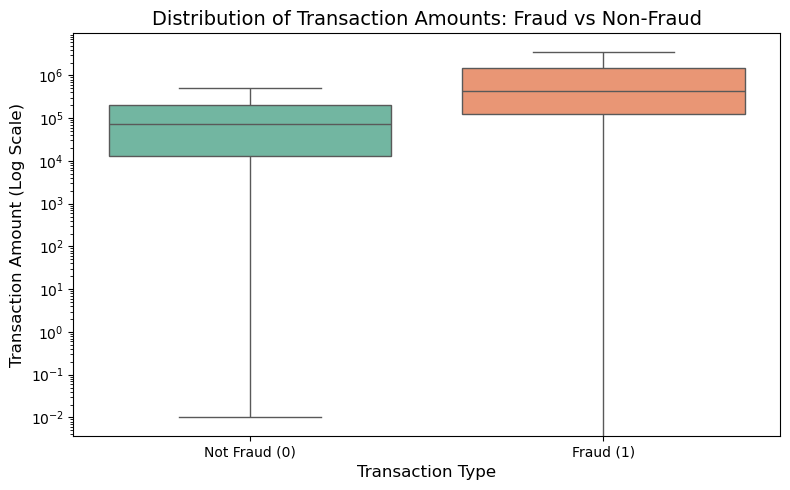

In [12]:

plt.figure(figsize=(8, 5))

# Updated: Assign x to hue and disable legend
sns.boxplot(x='isFraud', y='amount', hue='isFraud', data=df,
            showfliers=False, palette='Set2', legend=False)

# Use log scale to manage high-value transactions
plt.yscale('log')

# Improve title and labels
plt.title("Distribution of Transaction Amounts: Fraud vs Non-Fraud", fontsize=14)
plt.xlabel("Transaction Type", fontsize=12)
plt.ylabel("Transaction Amount (Log Scale)", fontsize=12)
plt.xticks([0, 1], ['Not Fraud (0)', 'Fraud (1)'])

plt.tight_layout()
plt.show()


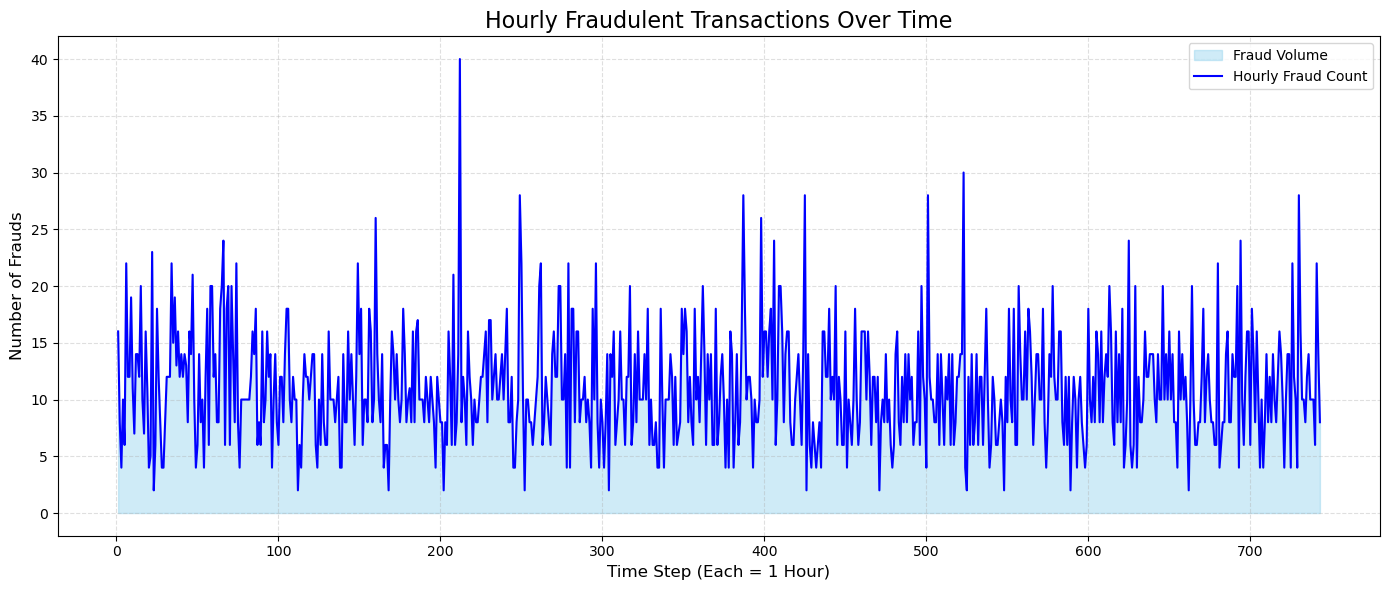

In [13]:

# Group by time step and sum frauds
fraud_by_step = df[df['isFraud'] == 1].groupby('step')['isFraud'].count()

# Plotting
plt.figure(figsize=(14, 6))

# Area fill
plt.fill_between(fraud_by_step.index, fraud_by_step.values,
                 color='skyblue', alpha=0.4, label='Fraud Volume')

# Line on top
plt.plot(fraud_by_step.index, fraud_by_step.values,
         color='blue', linewidth=1.5, label='Hourly Fraud Count')

# Add grid, labels, and legend
plt.grid(True, linestyle='--', alpha=0.4)
plt.title("Hourly Fraudulent Transactions Over Time", fontsize=16)
plt.xlabel("Time Step (Each = 1 Hour)", fontsize=12)
plt.ylabel("Number of Frauds", fontsize=12)
plt.legend()
plt.tight_layout()
plt.show()


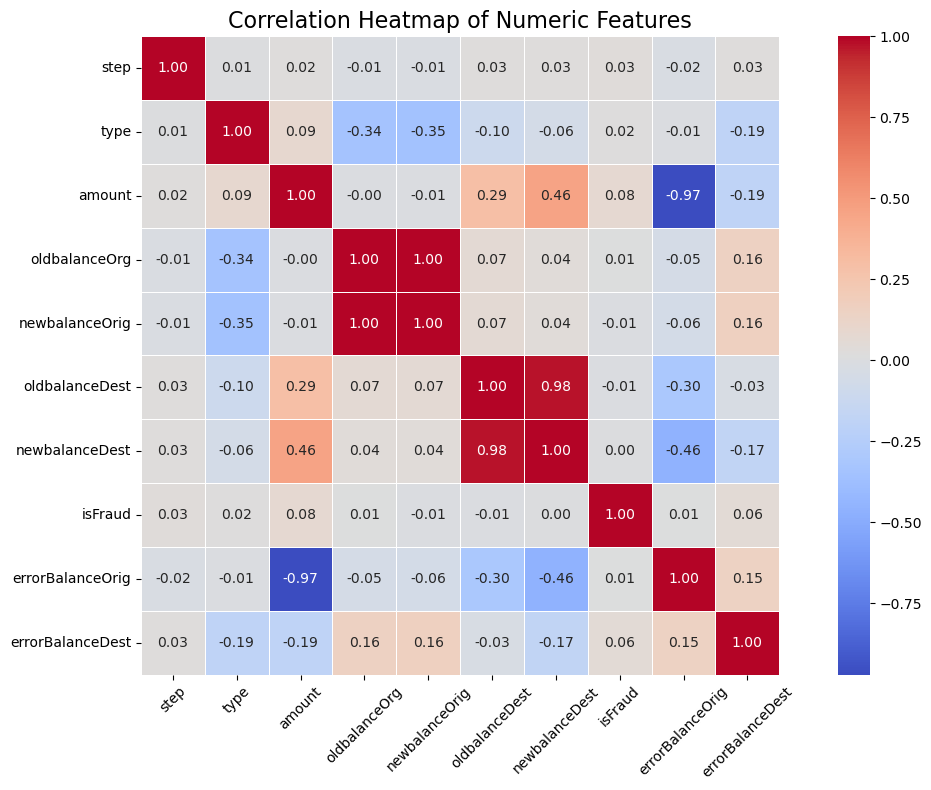

In [14]:


# Compute correlation matrix
corr_matrix = df.corr(numeric_only=True)  # Optional if you're on newer pandas

# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5, square=True)

# Titles and layout
plt.title("Correlation Heatmap of Numeric Features", fontsize=16)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()



In [15]:
print("Shape of dataset:", df.shape)  # Output: (rows, columns)


Shape of dataset: (6362620, 11)


In [ ]:
X = df.drop("isFraud", axis=1)
y = df["isFraud"]

# Clean the Data
X = X.apply(pd.to_numeric, errors='coerce')
X = X.fillna(0)
X = X.replace([np.inf, -np.inf], 0)

# Train-Test Split (Stratified)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

print("✅ Data split completed")
print("Training samples:", X_train.shape[0])
print("Testing samples:", X_test.shape[0])

# Train Random Forest Model
rf = RandomForestClassifier(
    n_estimators=100,
    class_weight='balanced',  # Helps with class imbalance
    random_state=42,
    n_jobs=-1                 # Use all CPU cores for faster training
)

print("🚀 Training model on full dataset...")
rf.fit(X_train, y_train)
print("✅ Model training completed!")

# Predict and Evaluate
y_pred = rf.predict(X_test)

print("\n📊 Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\n📋 Classification Report:\n", classification_report(y_test, y_pred))
print("🔍 ROC AUC Score:", roc_auc_score(y_test, y_pred))


✅ Data split completed
Training samples: 4771965
Testing samples: 1590655
🚀 Training model on full dataset...
✅ Model training completed!

📊 Confusion Matrix:
 [[1588602       0]
 [      6    2047]]

📋 Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00   1588602
           1       1.00      1.00      1.00      2053

    accuracy                           1.00   1590655
   macro avg       1.00      1.00      1.00   1590655
weighted avg       1.00      1.00      1.00   1590655

🔍 ROC AUC Score: 0.9985387238188017


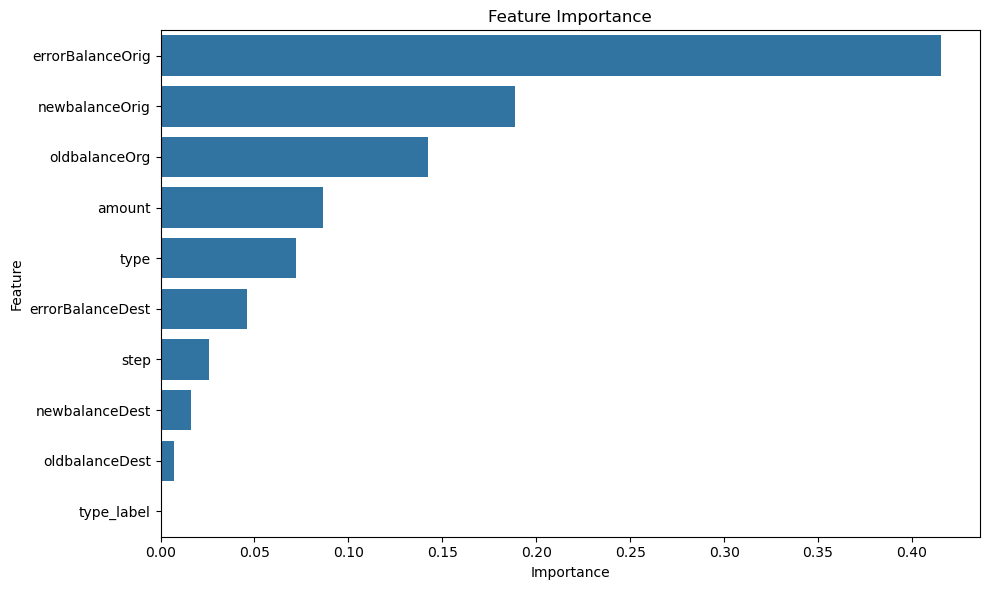

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

importances = rf.feature_importances_
features = X.columns
fi_df = pd.DataFrame({'Feature': features, 'Importance': importances}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=fi_df)
plt.title("Feature Importance")
plt.tight_layout()
plt.show()


In [18]:
import joblib
joblib.dump(rf, 'fraud_detection_model.pkl')


['fraud_detection_model.pkl']